In [1]:
import optparse
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import katdal
#import scape
import scikits.fitting as fit
#import gsm
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord
#from katsdpscripts import git_info
from matplotlib.offsetbox import AnchoredText
import time


In [2]:
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])

(10.0, 0.8, 1.5)
(14.0, 1.5, 1.5)


In [3]:
print ('start @ ' + time.asctime(time.localtime(time.time())) +'#')

start @ Thu Jan  2 16:10:23 2025#


In [4]:
class Spill_Temp_UHF:
    """Load spillover models and interpolate to centre observing frequency."""
    def __init__(self,filename=None):
        """ The class Spill_temp reads the spillover model from file and
        produces fitted functions for a frequency
        The class/__init__function takes in one parameter:
        filename : (default=none) This is the filename containing
               the spillover model ,this file has 3 cols:
               theta(Degrees, 0 at Zenith),temperature (MHz),Frequency (MHz)
               if there are no files zero spillover is assumed.
               function save makes a file of the correct format
        returns :
               dict  spill with two elements 'HH' 'VV' that
               are interpolation functions that take in elevation & Frequency(MHz)
               and return temperature in Kelvin.
        """
#TODO Need to sort out better frequency interpolation & example
        try:
            datafile =np.loadtxt(filename)
            elevation = 90.-datafile[1:,0]
            numfreqs = (datafile.shape[1]-1)//2
            freqs= datafile[0,1::2]
            spill_hh_data=datafile[1:, 1::2]
            spill_vv_data=datafile[1:, 2::2]
            #modified here!!!!!!!!!
            #modified here!!!!!!!!!
                        
            T_H = fit.Spline2DGridFit(degree=(3,3))
            T_H.fit((elevation, freqs), spill_hh_data)
            
            T_V = fit.Spline2DGridFit(degree=(3,3))
            T_V.fit((elevation, freqs), spill_vv_data)
            
            #modification ended
            
            self.spill = {}
            self.spill['HH'] = T_H # The HH and VV is a scape thing
            self.spill['VV'] = T_V
            #print self.spill['HH']((90.-elevation_list,freq_list))

        except IOError:
            spillover_H = np.array([[0.,90.,0.,90.],[0.,0.,0.,0.],[500.,500.,1100.,1100.]]) #for UHF 
            spillover_V = np.array([[0.,90.,0.,90.],[0.,0.,0.,0.],[500.,500.,1100.,1100.]]) #for UHF 
            spillover_H[0]= 90-spillover_H[0]
            spillover_V[0]= 90-spillover_V[0]
            T_H = fit.Delaunay2DScatterFit()
            T_V = fit.Delaunay2DScatterFit()
            T_H.fit(spillover_H[[0,2],:],spillover_H[1,:])
            T_V.fit(spillover_V[[0,2],:],spillover_V[1,:])
            self.spill = {}
            self.spill['HH'] = T_H # The HH and VV is a scape thing
            self.spill['VV'] = T_V
            warnings.warn('Warning: Failed to load Spillover models, setting models to zeros')
            print ("error")
        # the models are in a format of theta=0  == el=90



In [5]:
SpillOver_UHF = Spill_Temp_UHF(filename='/users/jywang/MeerKAT/model_test/mkat_model/spillover-models/mkat/MK_U_Tspill_AsBuilt_atm_mask.dat')

# Freqs in table [580, 700, 840, 900, 1015] MHz with H/V

In [6]:
data=np.loadtxt('/users/jywang/MeerKAT/model_test/mkat_model/spillover-models/mkat/MK_U_Tspill_AsBuilt_atm_mask.dat')

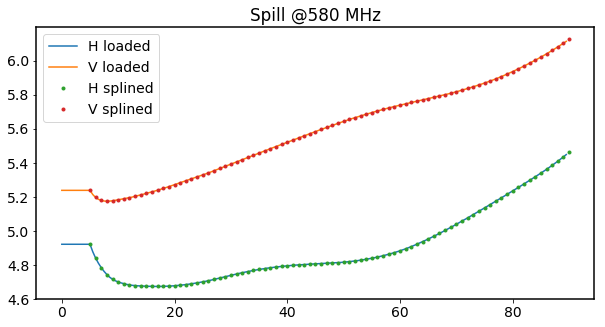

In [7]:
#confirm the plot with raw and with fitted value overlaps
freq_local=580
els=np.array(np.arange(0,90,0.5))
Tspill_HH=SpillOver_UHF.spill['HH']((els, freq_local)) 
Tspill_VV=SpillOver_UHF.spill['VV']((els, freq_local))
#print Tspill_HH
plt.figure(figsize=(10,5))
plt.plot(els, Tspill_HH,'-')
plt.plot(els, Tspill_VV,'-')
plt.plot(90.-data[1:, 0], data[1:, 1],'.') #for 580 MHz
plt.plot(90.-data[1:, 0], data[1:, 2],'.')
plt.legend(['H loaded', 'V loaded', 'H splined', 'V splined'])
plt.title('Spill @'+str(freq_local)+' MHz')
plt.show()

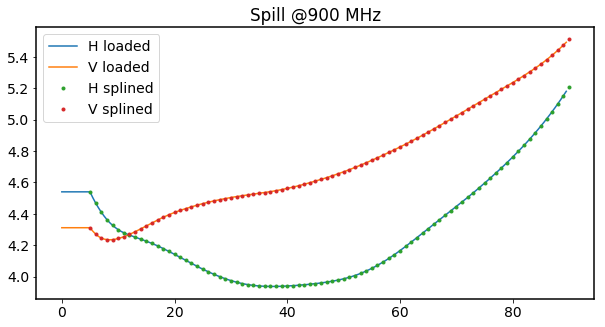

In [8]:
#confirm the plot with raw and with fitted value overlaps
freq_local=900
els=np.array(np.arange(0,90,0.5))
Tspill_HH=SpillOver_UHF.spill['HH']((els, freq_local)) 
Tspill_VV=SpillOver_UHF.spill['VV']((els, freq_local))
#print Tspill_HH
plt.figure(figsize=(10,5))
plt.plot(els, Tspill_HH,'-')
plt.plot(els, Tspill_VV,'-')
plt.plot(90.-data[1:, 0], data[1:, 7],'.') #for 900 MHz
plt.plot(90.-data[1:, 0], data[1:, 8],'.')
plt.legend(['H loaded', 'V loaded', 'H splined', 'V splined'])
plt.title('Spill @'+str(freq_local)+' MHz')
plt.show()

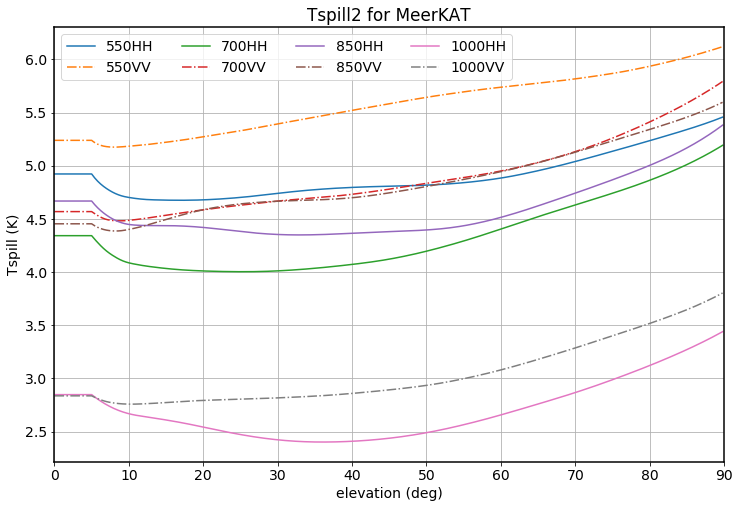

In [9]:
###for google doc#####
els=np.array(np.arange(0,90,0.2))
legend=[]
plt.figure(figsize=(12,8))
for freq_i in np.arange(550,1100,150): #MHz
    
    npoints=np.shape(els)[0] 
    freqs=np.ones(npoints)*freq_i 

    #modified here!!!!!!!!!!!!
    #modified here!!!!!!!!!!!!
    #x=np.zeros([2,npoints]) 
    #x[0,:]=els 
    #x[1,:]=freqs
    Tspill_HH=SpillOver_UHF.spill['HH']((els, freq_i)) 
    Tspill_VV=SpillOver_UHF.spill['VV']((els, freq_i)) 
    
    #modification ended
    plt.plot(els, Tspill_HH,'-')
    plt.plot(els, Tspill_VV,'-.')
    legend.append(str(freq_i)+'HH')
    legend.append(str(freq_i)+'VV')
plt.xlim(0,90.)
plt.grid()
plt.legend(legend,ncol=4)
plt.xlabel('elevation (deg)')
plt.ylabel('Tspill (K)')
plt.title('Tspill2 for MeerKAT')
plt.show()

In [10]:
print ('end @ ' + time.asctime(time.localtime(time.time())) +'#')

end @ Thu Jan  2 16:10:23 2025#
